Imports

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [136]:
# Function to show various error measurement
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = np.mean((forecast - actual)**2)  # MSE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    #corr = np.corrcoef(forecast, actual)[0,1]   # corr
    #mins = np.amin(np.hstack([forecast[:,None], 
    #                          actual[:,None]]), axis=1)
    #maxs = np.amax(np.hstack([forecast[:,None], 
    #                          actual[:,None]]), axis=1)
    #minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    #return({'mape':mape, 'me':me, 'mae': mae, 
    #        'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
    #        'corr':corr, 'minmax':minmax})
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'mse':mse, 'rmse':rmse})

In [137]:
#data_path ='BillEstimateGHL.csv'
data_path ='BillEstimateMEH.csv'
#data_path ='BillEstimatePEH.csv'
#data_path ='BillEstimatePNH.csv'
df = pd.read_csv(data_path)
df.head()

,ACTUAL_CASE_NUMBER,ACTUAL_TREATMENT_CATEGORY,ACTUAL_PATIENT_NUMBER,ACTUAL_PRIMARY_DIAGNOSIS_SID,ACTUAL_CASE_INSTITUTION,ACTUAL_ADMISSION_DTE,ACTUAL_LOS,ACTUAL_ICU_HDU_LOS,ACTUAL_SURGICAL_CODE_1,ACTUAL_SURGICAL_CODE_2,...,NATIONALITY,RESID_CTY,RESID_POSTALCODE,OCCUPATION,RESID_GEOAREA,NONRESID_FLAG,IDENT_TYPE,CONT_POSTAL,CONT_RELATION,TOTAL_HOSP
0,2018115219,endo,5148520,13220,meh,11/16/2018,0,NaN,sf701i,NaN,...,singapore,singapore,679695.0,NaN,NaN,n,pink s'pore ic,688536.0,mother,759.63
1,2018115095,endo,6098582,28108,meh,11/16/2018,0,NaN,sf704c,sf701i,...,singapore,singapore,670257.0,NaN,singapore,n,pink s'pore ic,670257.0,mother,1347.64
2,2018111914,endo,5023003,27226,meh,11/16/2018,0,NaN,sf702c,sf701i,...,indonesia,singapore,180232.0,NaN,singapore,y,others,180232.0,sister,1226.29
3,2018115182,dc,4428909,17952,meh,11/16/2018,0,NaN,sg718b,sk759e,...,singapore,singapore,370031.0,NaN,singapore,n,pink s'pore ic,370031.0,m-spouse,3362.96
4,2018115051,sgl,5426581,28726,meh,11/16/2018,1,NaN,NaN,NaN,...,singapore,singapore,530130.0,NaN,singapore,n,pink s'pore ic,530130.0,sister,9025.82


In [138]:
info = []
for col in df.columns:
    non_null  = len(df) - np.sum(pd.isna(df[col]))
    num_unique = df[col].nunique()
    col_type = str(df[col].dtype)

    info.append([col, non_null, num_unique, col_type])

features_info = pd.DataFrame(info, columns = ['colName','non-null values', 'unique', 'dtype'])

display(features_info)

,colName,non-null values,unique,dtype
0,ACTUAL_CASE_NUMBER,21581,21581,int64
1,ACTUAL_TREATMENT_CATEGORY,21581,23,object
2,ACTUAL_PATIENT_NUMBER,21581,19334,int64
3,ACTUAL_PRIMARY_DIAGNOSIS_SID,21581,2378,int64
4,ACTUAL_CASE_INSTITUTION,21581,1,object
5,ACTUAL_ADMISSION_DTE,21581,442,object
6,ACTUAL_LOS,21581,48,int64
7,ACTUAL_ICU_HDU_LOS,49,14,float64
8,ACTUAL_SURGICAL_CODE_1,15621,970,object
9,ACTUAL_SURGICAL_CODE_2,5742,541,object


Data Pre-Processing

In [139]:
df.shape
df.describe()

,ACTUAL_CASE_NUMBER,ACTUAL_PATIENT_NUMBER,ACTUAL_PRIMARY_DIAGNOSIS_SID,ACTUAL_LOS,ACTUAL_ICU_HDU_LOS,ADM_DATE,CASE_NO,ETBS_LOS,PATIENT_TYPE,PATIENT_NUMBER,RESID_POSTALCODE,CONT_POSTAL,TOTAL_HOSP
count,2.158100e+04,2.158100e+04,21581.000000,21581.000000,49.000000,2.158100e+04,1.636600e+04,20957.000000,0.0,2.154100e+04,1.572800e+04,15077.000000,21581.000000
mean,2.018992e+09,5.247495e+06,19058.162504,1.515036,5.551020,2.018997e+07,2.019128e+09,1.480031,NaN,5.247466e+06,4.498934e+05,447976.637660,7007.375547
std,3.839995e+05,1.015405e+06,6374.529726,2.953677,4.041767,3.868861e+03,2.370173e+05,1.082071,NaN,1.015384e+06,2.118993e+05,206145.851806,11891.259583
min,2.018077e+09,3.000164e+06,0.000000,0.000000,2.000000,2.018112e+07,2.018070e+09,1.000000,NaN,3.000164e+06,1.808000e+03,11640.000000,591.390000
25%,2.019017e+09,4.329712e+06,13808.000000,0.000000,2.000000,2.019022e+07,2.019043e+09,1.000000,NaN,4.329415e+06,2.599100e+05,259738.000000,1925.510000
50%,2.019052e+09,5.672003e+06,19708.000000,1.000000,4.000000,2.019052e+07,2.019072e+09,1.000000,NaN,5.671630e+06,4.706050e+05,468661.000000,3930.600000
75%,2.019095e+09,6.140041e+06,24784.000000,2.000000,7.000000,2.019092e+07,2.019106e+09,2.000000,NaN,6.140162e+06,5.969238e+05,596237.000000,8050.710000
max,2.020010e+09,6.260939e+06,28784.000000,98.000000,18.000000,2.020013e+07,2.020010e+09,32.000000,NaN,6.260939e+06,6.050811e+06,828840.000000,560189.110000


In [140]:
df.dtypes

ACTUAL_CASE_NUMBER                int64
ACTUAL_TREATMENT_CATEGORY        object
ACTUAL_PATIENT_NUMBER             int64
ACTUAL_PRIMARY_DIAGNOSIS_SID      int64
ACTUAL_CASE_INSTITUTION          object
ACTUAL_ADMISSION_DTE             object
ACTUAL_LOS                        int64
ACTUAL_ICU_HDU_LOS              float64
ACTUAL_SURGICAL_CODE_1           object
ACTUAL_SURGICAL_CODE_2           object
ACTUAL_SURGICAL_CODE_3           object
ACTUAL_DIAGNOSIS_CODE            object
ADM_DATE                          int64
INST                             object
CASE_NO                         float64
ETBS_LOS                        float64
ETBS_ICU_HDU_LOS                 object
ETBS_MOVE_TYPE                   object
ETBS_TOSP_1                      object
ETBS_TOSP_2                      object
ETBS_TOSP_3                      object
ETBS_ICD10_1                     object
ETBS_ICD10_2                     object
ETBS_ICD10_3                     object
CASE_TYPE                        object


In [141]:
df = df.fillna(0)
df.head()

,ACTUAL_CASE_NUMBER,ACTUAL_TREATMENT_CATEGORY,ACTUAL_PATIENT_NUMBER,ACTUAL_PRIMARY_DIAGNOSIS_SID,ACTUAL_CASE_INSTITUTION,ACTUAL_ADMISSION_DTE,ACTUAL_LOS,ACTUAL_ICU_HDU_LOS,ACTUAL_SURGICAL_CODE_1,ACTUAL_SURGICAL_CODE_2,...,NATIONALITY,RESID_CTY,RESID_POSTALCODE,OCCUPATION,RESID_GEOAREA,NONRESID_FLAG,IDENT_TYPE,CONT_POSTAL,CONT_RELATION,TOTAL_HOSP
0,2018115219,endo,5148520,13220,meh,11/16/2018,0,0.0,sf701i,0,...,singapore,singapore,679695.0,0,0,n,pink s'pore ic,688536.0,mother,759.63
1,2018115095,endo,6098582,28108,meh,11/16/2018,0,0.0,sf704c,sf701i,...,singapore,singapore,670257.0,0,singapore,n,pink s'pore ic,670257.0,mother,1347.64
2,2018111914,endo,5023003,27226,meh,11/16/2018,0,0.0,sf702c,sf701i,...,indonesia,singapore,180232.0,0,singapore,y,others,180232.0,sister,1226.29
3,2018115182,dc,4428909,17952,meh,11/16/2018,0,0.0,sg718b,sk759e,...,singapore,singapore,370031.0,0,singapore,n,pink s'pore ic,370031.0,m-spouse,3362.96
4,2018115051,sgl,5426581,28726,meh,11/16/2018,1,0.0,0,0,...,singapore,singapore,530130.0,0,singapore,n,pink s'pore ic,530130.0,sister,9025.82


EDA

In [142]:
df.corr()

,ACTUAL_CASE_NUMBER,ACTUAL_PATIENT_NUMBER,ACTUAL_PRIMARY_DIAGNOSIS_SID,ACTUAL_LOS,ACTUAL_ICU_HDU_LOS,ADM_DATE,CASE_NO,ETBS_LOS,PATIENT_TYPE,PATIENT_NUMBER,RESID_POSTALCODE,CONT_POSTAL,TOTAL_HOSP
ACTUAL_CASE_NUMBER,1.000000,0.048542,0.001552,0.028830,0.011631,0.990053,0.624940,0.020231,NaN,0.069046,-0.006546,-0.009396,0.027474
ACTUAL_PATIENT_NUMBER,0.048542,1.000000,0.001620,0.018270,-0.006837,0.047733,0.042575,0.029093,NaN,0.975058,-0.032137,-0.080928,0.002811
ACTUAL_PRIMARY_DIAGNOSIS_SID,0.001552,0.001620,1.000000,0.006365,0.007801,0.003050,-0.011583,0.006757,NaN,0.003078,-0.013457,-0.008012,0.017457
ACTUAL_LOS,0.028830,0.018270,0.006365,1.000000,0.190255,0.027725,0.037195,0.405827,NaN,0.015137,-0.059178,-0.044116,0.717961
ACTUAL_ICU_HDU_LOS,0.011631,-0.006837,0.007801,0.190255,1.000000,0.011140,0.009548,0.027682,NaN,-0.006317,-0.020587,-0.009354,0.268476
ADM_DATE,0.990053,0.047733,0.003050,0.027725,0.011140,1.000000,0.616468,0.021272,NaN,0.068037,-0.006235,-0.008948,0.027795
CASE_NO,0.624940,0.042575,-0.011583,0.037195,0.009548,0.616468,1.000000,0.028299,NaN,0.036310,-0.017552,-0.019776,0.033737
ETBS_LOS,0.020231,0.029093,0.006757,0.405827,0.027682,0.021272,0.028299,1.000000,NaN,0.024282,-0.060587,-0.044741,0.371017
PATIENT_TYPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PATIENT_NUMBER,0.069046,0.975058,0.003078,0.015137,-0.006317,0.068037,0.036310,0.024282,NaN,1.000000,-0.019986,-0.068118,0.000452


In [143]:
# drop columns
col_drop = ['ACTUAL_CASE_NUMBER', 'ACTUAL_PATIENT_NUMBER','CASE_NO','ETBS_ICU_HDU_LOS','ETBS_ICD10_3','CASE_TYPE','PATIENT_TYPE','ADMITTING_SMC_NUMBER','ATTENDING_SMC_NUMBER','REFERRAL_SMC_NUMBER','ADM_CLASS_DISC','PATIENT_NUMBER','OCCUPATION','CONT_RELATION','ACTUAL_PRIMARY_DIAGNOSIS_SID','DOB','ACTUAL_CASE_INSTITUTION']
df1 =  df.drop(col_drop, axis=1)
df1 =  df1.reset_index()

In [144]:
X = df1[['ACTUAL_TREATMENT_CATEGORY','ACTUAL_ADMISSION_DTE', 'ACTUAL_LOS','ACTUAL_ICU_HDU_LOS','ACTUAL_SURGICAL_CODE_1','ACTUAL_SURGICAL_CODE_2','ACTUAL_SURGICAL_CODE_3','ACTUAL_DIAGNOSIS_CODE','ADM_DATE','INST','ETBS_LOS','ETBS_MOVE_TYPE','ETBS_TOSP_1','ETBS_TOSP_2','ETBS_TOSP_3','ETBS_ICD10_1','ETBS_ICD10_2','ADMISSION_TYPE','TREATMENT_CATEGORY','REFERRAL_TYPE','DEPT_OU','GENDER','MARITAL_STATUS','RELIGION','NATIONALITY','RESID_CTY','RESID_POSTALCODE','RESID_GEOAREA','NONRESID_FLAG','IDENT_TYPE','CONT_POSTAL']]

In [145]:
display(X)

,ACTUAL_TREATMENT_CATEGORY,ACTUAL_ADMISSION_DTE,ACTUAL_LOS,ACTUAL_ICU_HDU_LOS,ACTUAL_SURGICAL_CODE_1,ACTUAL_SURGICAL_CODE_2,ACTUAL_SURGICAL_CODE_3,ACTUAL_DIAGNOSIS_CODE,ADM_DATE,INST,...,GENDER,MARITAL_STATUS,RELIGION,NATIONALITY,RESID_CTY,RESID_POSTALCODE,RESID_GEOAREA,NONRESID_FLAG,IDENT_TYPE,CONT_POSTAL
0,endo,11/16/2018,0,0.0,sf701i,0,0,k229,20181116,meh,...,female,single,other,singapore,singapore,679695.0,0,n,pink s'pore ic,688536.0
1,endo,11/16/2018,0,0.0,sf704c,sf701i,0,k210,20181116,meh,...,male,single,0,singapore,singapore,670257.0,singapore,n,pink s'pore ic,670257.0
2,endo,11/16/2018,0,0.0,sf702c,sf701i,0,k590,20181116,meh,...,female,divrce,other,indonesia,singapore,180232.0,singapore,y,others,180232.0
3,dc,11/16/2018,0,0.0,sg718b,sk759e,0,n359,20181116,meh,...,female,marri,0,singapore,singapore,370031.0,singapore,n,pink s'pore ic,370031.0
4,sgl,11/16/2018,1,0.0,0,0,0,c119,20181116,meh,...,female,marri,christian,singapore,singapore,530130.0,singapore,n,pink s'pore ic,530130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21576,2bd,1/30/2020,1,0.0,sb712k,0,0,s833,20200130,meh,...,female,marri,0,american,singapore,266216.0,singapore,y,uin for non-ic,266216.0
21577,2bd,1/30/2020,1,0.0,0,0,0,c9000,20200130,meh,...,male,marri,0,indonesian,indonesia,0.0,"indonesia,surabaya",y,others,576150.0
21578,dc,1/31/2020,0,0.0,sl723e,0,0,h001,20200131,meh,...,male,marri,0,bangladeshi,singapore,151073.0,singapore,y,others,151073.0
21579,dc,1/31/2020,0,0.0,sa704b,0,0,r92,20200131,meh,...,female,marri,christian,sri lankan,sri lanka,0.0,"srilanka,colombo",y,others,0.0


In [146]:
info = []
for col in df1.columns:
    non_null  = len(df1) - np.sum(pd.isna(df1[col]))
    num_unique = df1[col].nunique()
    col_type = str(df1[col].dtype)

    info.append([col, non_null, num_unique, col_type])

features_info = pd.DataFrame(info, columns = ['colName','non-null values', 'unique', 'dtype'])

display(features_info)

,colName,non-null values,unique,dtype
0,index,21581,21581,int64
1,ACTUAL_TREATMENT_CATEGORY,21581,23,object
2,ACTUAL_ADMISSION_DTE,21581,442,object
3,ACTUAL_LOS,21581,48,int64
4,ACTUAL_ICU_HDU_LOS,21581,15,float64
5,ACTUAL_SURGICAL_CODE_1,21581,971,object
6,ACTUAL_SURGICAL_CODE_2,21581,542,object
7,ACTUAL_SURGICAL_CODE_3,21581,289,object
8,ACTUAL_DIAGNOSIS_CODE,21581,2373,object
9,ADM_DATE,21581,442,int64


In [147]:
X = pd.get_dummies(data=X, drop_first=True)
X.head()

,ACTUAL_LOS,ACTUAL_ICU_HDU_LOS,ADM_DATE,ETBS_LOS,RESID_POSTALCODE,CONT_POSTAL,ACTUAL_TREATMENT_CATEGORY_2bdw14,ACTUAL_TREATMENT_CATEGORY_4bd,ACTUAL_TREATMENT_CATEGORY_4bdw14,ACTUAL_TREATMENT_CATEGORY_argon,...,"RESID_GEOAREA_vietnam,quangninh","RESID_GEOAREA_vietnam,thaibinh","RESID_GEOAREA_vietnam,vinh",NONRESID_FLAG_n,NONRESID_FLAG_y,IDENT_TYPE_blue s'pore ic,IDENT_TYPE_m'sian ic,IDENT_TYPE_others,IDENT_TYPE_pink s'pore ic,IDENT_TYPE_uin for non-ic
0,0,0.0,20181116,1.0,679695.0,688536.0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0.0,20181116,1.0,670257.0,670257.0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0.0,20181116,1.0,180232.0,180232.0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,0,0.0,20181116,1.0,370031.0,370031.0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1,0.0,20181116,1.0,530130.0,530130.0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [148]:
Y = df['TOTAL_HOSP']

Creating a train and test dataset.

In [149]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12948, 7794)
(8633, 7794)
(12948,)
(8633,)


In [150]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [151]:
y_pred = model.predict(X_test)

In [152]:
type(y_pred)

numpy.ndarray

In [153]:
type(y_test)

pandas.core.series.Series

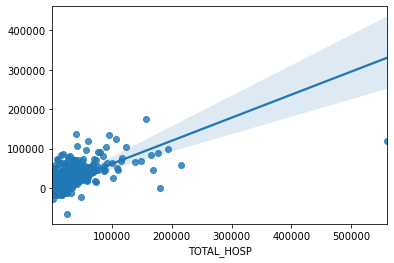

In [154]:
sns.regplot(y_test,y_pred)

In [155]:
# MSE
print('Mean squared error: %.2f'
      % mean_squared_error(y_test,y_pred, squared=True))

# RMSE
print('Root Mean squared error: %.2f'
      % mean_squared_error(y_test,y_pred, squared=False))

# MAE
print('Mean absolute error: %.2f'
      % mean_absolute_error(y_test,y_pred))

Mean squared error: 70738314.60
Root Mean squared error: 8410.61
Mean absolute error: 3132.34


In [156]:
forecast_accuracy(y_pred, y_test)

{'mape': 0.6522548100978689,
 'me': -177.5038687481759,
 'mae': 3132.3364195796203,
 'mpe': 0.12027010180713012,
 'mse': 70738314.60266145,
 'rmse': 8410.607267175268}

Neural Networks ( Sequential )

In [157]:
NN_model = Sequential()

In [158]:
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

In [159]:
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

In [160]:
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [161]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 128)               997760    
_________________________________________________________________
dense_15 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 1,162,625
Trainable params: 1,162,625
Non-trainable params: 0
_________________________________________________________________


In [162]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [163]:
NN_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/100
313/324 [===========================>..] - ETA: 0s - loss: 8321.4424 - mean_absolute_error: 8321.4424
Epoch 00001: val_loss improved from inf to 4787.12451, saving model to Weights-001--4787.12451.hdf5
324/324 [==============================] - 2s 6ms/step - loss: 8239.9795 - mean_absolute_error: 8239.9795 - val_loss: 4787.1245 - val_mean_absolute_error: 4787.1245
Epoch 2/100
316/324 [============================>.] - ETA: 0s - loss: 5184.0811 - mean_absolute_error: 5184.0811
Epoch 00002: val_loss did not improve from 4787.12451
324/324 [==============================] - 2s 5ms/step - loss: 5173.2739 - mean_absolute_error: 5173.2739 - val_loss: 4824.5454 - val_mean_absolute_error: 4824.5454
Epoch 3/100
323/324 [============================>.] - ETA: 0s - loss: 5062.2451 - mean_absolute_error: 5062.2451
Epoch 00003: val_loss did not improve from 4787.12451
324/324 [==============================] - 2s 5ms/step - loss: 5065.3750 - mean_absolute_error: 5065.3750 - val_loss: 50

In [164]:
predictions = NN_model.predict(X_test)

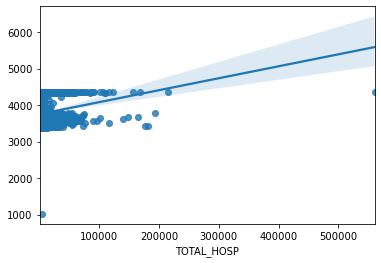

In [165]:
sns.regplot(y_test,predictions)

In [166]:
# MSE
print('Mean squared error: %.2f'
      % mean_squared_error(y_test,predictions, squared=True))

# RMSE
print('Root Mean squared error: %.2f'
      % mean_squared_error(y_test,predictions, squared=False))

# MAE
print('Mean absolute error: %.2f'
      % mean_absolute_error(y_test,predictions))

Mean squared error: 153109249.17
Root Mean squared error: 12373.73
Mean absolute error: 4874.60


In [167]:
forecast_accuracy(predictions, y_test)

Exception: Data must be 1-dimensional

In [168]:
model = RandomForestRegressor()
model.fit(X_train,y_train)

RandomForestRegressor()

In [121]:
predicted_forest = model.predict(X_test)

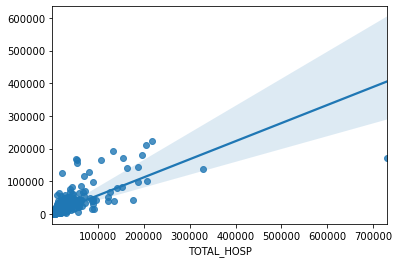

In [122]:
sns.regplot(y_test,predicted_forest)

In [123]:
# MSE
print('Mean squared error: %.2f'
      % mean_squared_error(y_test,predicted_forest, squared=True))

# RMSE
print('Root Mean squared error: %.2f'
      % mean_squared_error(y_test,predicted_forest, squared=False))

# MAE
print('Mean absolute error: %.2f'
      % mean_absolute_error(y_test,predicted_forest))

Mean squared error: 80450550.48
Root Mean squared error: 8969.42
Mean absolute error: 2069.38


In [124]:
forecast_accuracy(predicted_forest, y_test)

{'mape': 0.3468913216409671,
 'me': -396.2196567773451,
 'mae': 2069.38062649955,
 'mpe': 0.12120644860657105,
 'mse': 80450550.48315717,
 'rmse': 8969.423085302486}

In [125]:
XGBModel = XGBRegressor()
XGBModel.fit(X_train,y_train , verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [126]:
XGBpredictions = XGBModel.predict(X_test)

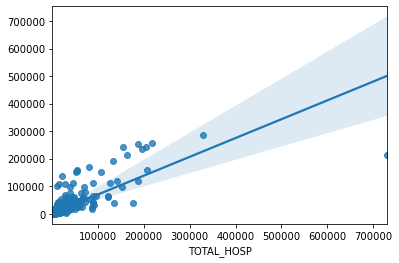

In [127]:
sns.regplot(y_test,XGBpredictions)

In [128]:
# MSE
print('Mean squared error: %.2f'
      % mean_squared_error(y_test,XGBpredictions, squared=True))

# RMSE
print('Root Mean squared error: %.2f'
      % mean_squared_error(y_test,XGBpredictions, squared=False))

# MAE
print('Mean absolute error: %.2f'
      % mean_absolute_error(y_test,XGBpredictions))

Mean squared error: 70582758.54
Root Mean squared error: 8401.35
Mean absolute error: 2097.85


In [129]:
forecast_accuracy(XGBpredictions, y_test)

{'mape': 0.4179715600785779,
 'me': 37.48459491954715,
 'mae': 2097.8492469866064,
 'mpe': 0.22924739651142068,
 'mse': 70582758.53612088,
 'rmse': 8401.354565551967}